In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/1332faces.zip' -d '/content/imgData'

In [6]:
from PIL import Image
import numpy as np
import glob

In [ ]:
cwd = '/content/imgData/dataset'
image_list_part1 = []
data_list = []
for filename in glob.glob(cwd + "//0001-3000//*.jpg"):
    im = Image.open(filename)
    image_list_part1.append(im)    
    data_list.append(np.asarray(im))

# image_list_part2 = []
# for filename in glob.glob(cwd + "//3001-6000//*.jpg"):
#     im = Image.open(filename)
#     image_list_part2.append(im)
#     print(im.size)
#     data_list.append(np.asarray(im))

# image_list_part3 = []
# for filename in glob.glob(cwd + "//6001-9000//*.jpg"):
#     im = Image.open(filename)
#     image_list_part3.append(im)
#     print(im.size)
#     data_list.append(np.asarray(im))

# image_list_part4 = []
# for filename in glob.glob(cwd + "//9001-13322//*.jpg"):
#     im = Image.open(filename)
#     image_list_part4.append(im)
#     print(im.size)
#     data_list.append(np.asarray(im))

In [72]:

# You just need to compare the aspect ratios - depending on which is larger, that will tell you whether to chop off the sides or the top and bottom. e.g. how about:

def resizeImg(image, ideal_width, ideal_height):
  width  = image.size[0]
  height = image.size[1]
  aspect = width / float(height)
  ideal_aspect = ideal_width / float(ideal_height)
  if aspect > ideal_aspect:
      # Then crop the left and right edges:
      new_width = int(ideal_aspect * height)
      offset = (width - new_width) / 2
      resize = (offset, 0, width - offset, height)
  else:
      # ... crop the top and bottom:
      new_height = int(width / ideal_aspect)
      offset = (height - new_height) / 2
      resize = (0, offset, width, height - offset)
  thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
  return thumb
  
# 灰階轉換公式
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=305x382 at 0x7F4CBF15C198>


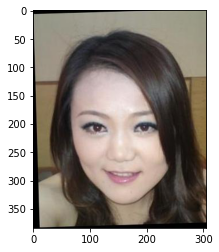

In [93]:
print(image_list_part1[0])
plt.imshow(image_list_part1[2])

In [95]:
trainX = []
for img in image_list_part1:
  img = resizeImg(image = img, ideal_width = 64, ideal_height = 64)
  image_sequence = img.getdata()
  image_array = np.array(image_sequence)
  trainX.append(rgb2gray(image_array)/255) # normalize to 0 ~ 1
trainFaces = np.array(trainX)
print(trainFaces.shape)

(3000, 4096)


[[0.01216863 0.25392941 0.32110588 ... 0.30718824 0.30218431 0.30267451]
 [0.79043529 0.9238549  0.90149804 ... 0.10144706 0.09590588 0.10541176]
 [0.40823137 0.60533725 0.5721098  ... 0.14596078 0.34581961 0.38955686]
 ...
 [0.59565098 0.8349098  0.79803922 ... 0.85176863 0.85176863 0.85176863]
 [0.43694902 0.43347451 0.42955294 ... 0.00622353 0.00558431 0.00347451]
 [0.         0.         0.         ... 0.6146     0.64796863 0.42896471]]


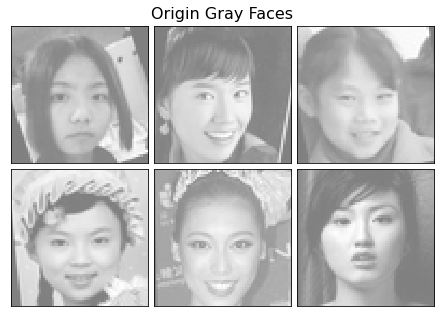

In [102]:
imgIndex = 9
plot_gallery("Origin Gray Faces", arr[imgIndex:imgIndex + 6])
print(trainFaces)

# PCA

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [58]:
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time
import logging

In [37]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [104]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,random_state=RandomState(0))
faces = trainFaces

n_samples, n_features = faces.shape
print(faces.shape)

(3000, 4096)


In [105]:
# global centering
faces_centered = faces - faces.mean(axis=0)

In [106]:
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 3000 faces


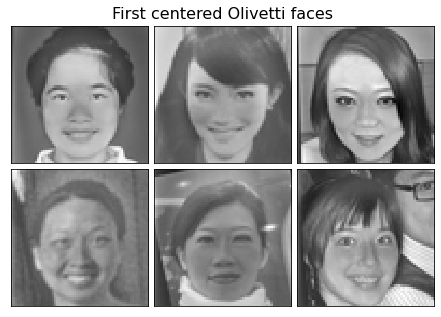

In [107]:
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

In [73]:
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=20),
     True),
]

In [ ]:
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

In [ ]:
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    #('Dictionary learning - positive code',
    #    decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
    #                                              n_iter=50, batch_size=3,
    #                                              fit_algorithm='cd',
    #                                              random_state=rng,
    #                                              positive_code=True),
    # True),
    ('Dictionary learning - positive dictionary & code',
        decomposition.MiniBatchDfictionaryLearning(n_components=15, alpha=0.1,
                                                   n_iter=50, batch_size=3,
                                                   fit_algorithm='cd',
                                                   random_state=rng,
                                                   positive_dict=True,
                                                   positive_code=True),
     True),
]

In [ ]:
for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], cmap=plt.cm.RdBu)

plt.show()

In [156]:
print(trainFaces.shape[0])

3000


In [158]:
from sklearn.decomposition import PCA

X_train = trainFaces
n_samples = trainFaces.shape[0]
h = 64
w = 64
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time() #計時
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
#進行降維
X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 3000 faces
done in 2.524s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.164s


# 臉部分群

https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/

In [141]:
# DBSCAN 
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [144]:
X = trainFaces
print(X)

[[0.01216863 0.25392941 0.32110588 ... 0.30718824 0.30218431 0.30267451]
 [0.79043529 0.9238549  0.90149804 ... 0.10144706 0.09590588 0.10541176]
 [0.40823137 0.60533725 0.5721098  ... 0.14596078 0.34581961 0.38955686]
 ...
 [0.59565098 0.8349098  0.79803922 ... 0.85176863 0.85176863 0.85176863]
 [0.43694902 0.43347451 0.42955294 ... 0.00622353 0.00558431 0.00347451]
 [0.         0.         0.         ... 0.6146     0.64796863 0.42896471]]


In [146]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 3000


ValueError: ignored

In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)


In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Chinese-Whisper分類演算法

https://www.itread01.com/content/1544826095.html
Library: https://github.com/nlpub/chinese-whispers-python

In [136]:
import networkx as nx
from chinese_whispers import chinese_whispers, aggregate_clusters
import matplotlib as plt

In [137]:
# chinese_whispers(G, weighting='top', iterations=20)
G = nx.karate_club_graph()

# Perform clustering of G, parameters weighting and seed can be omitted
chinese_whispers(G, weighting='top', seed=1337) 

# Print the clusters in the descending order of size
print('ID\tCluster\n')

for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))



AttributeError: ignored

In [138]:
import matplotlib.pyplot as plt

colors = [1. / G.nodes[node]['label'] for node in G.nodes()]

nx.draw_networkx(G, cmap=plt.get_cmap('jet'), node_color=colors, font_color='white')

KeyError: ignored